<a href="https://colab.research.google.com/github/Sinabehzadifard/CyptoMarketPrediction/blob/main/Crypto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install python-binance
!pip install mpl-finance
import matplotlib.pyplot as plt
!pip install prophet
from prophet import Prophet

     |████████████████████████████████| 61kB 7.1MB/s 
     |████████████████████████████████| 1.3MB 28.8MB/s 
     |████████████████████████████████| 112kB 45.6MB/s 
     |████████████████████████████████| 286kB 40.3MB/s 
     |████████████████████████████████| 184kB 48.9MB/s 
     |████████████████████████████████| 296kB 38.5MB/s 
     |████████████████████████████████| 143kB 43.2MB/s 
     |████████████████████████████████| 71kB 8.1MB/s 
     |████████████████████████████████| 51kB 4.9MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-cp37-none-any.whl size=6639674 sha256=7c3f9e949b8adcc2ffce8664d02203d8b53095227b9b4ac7e40666a6809c7eda
  Stored in directory: /root/.cache/pip/wheels/92/1d/02/bc0a91bd3a84e060722075d2b0b68e875e37ec7dc49451d513
Successfully built prophet
ERROR: fbprophet 0.7.1 has requirement cmdstanpy==0.9.5, but you'll have cmdstanpy 0.9.68 which is incompatible.
  Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully 

In [2]:
import pandas as pd
import numpy as np

import time
import dateparser
import pytz
import json

import math  

import datetime as dt
from datetime import datetime, timedelta

from threading import Thread

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as mdates

from mpl_finance import candlestick_ochl

import datetime
from datetime import datetime


from sklearn import preprocessing, model_selection, neighbors, svm
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error

from tqdm import tqdm as tqdm

from binance.client import Client

In [3]:
def binanceDataFrame(klines):
  df = pd.DataFrame(klines.reshape(-1,12), dtype=float, columns=['Open Time',
                                                                 'Open',
                                                                 'High',
                                                                 'Low',
                                                                 'Close',
                                                                 'Volume',
                                                                 'Close Time',
                                                                 'Quote asset volume',
                                                                 'Number of trades',
                                                                 'Taker buy base asset volume',
                                                                 'Taker buy quote asset volume',
                                                                 'Can be ignored']);

  df['Open Time'] = pd.to_datetime(df['Open Time'], unit='ms')
  df['Close Time'] = pd.to_datetime(df['Close Time'], unit='ms')

  return df

In [4]:
"Binance API"
api_key = 'aHWF2puEzrzj4vaaPmvIFGW0rUI1FPr4dw26orntUulPA466mY8KRW9xzeF5iveJ'
api_secret = ''
client = Client(api_key, api_secret)

In [5]:
depth = client.get_order_book(symbol = 'BTCUSDT')

# Get BTCUSDT 1DAY from Binance

In [6]:
%%time
klines = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1HOUR, "1 March, 2021")
klines = np.array(klines)
df = binanceDataFrame(klines)

CPU times: user 146 ms, sys: 16.7 ms, total: 163 ms
Wall time: 2.8 s


In [7]:
df.to_excel("output.xlsx")

In [8]:
df.describe()

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Can be ignored
count,2186.000000,2186.000000,2186.000000,2186.000000,2186.000000,2.186000e+03,2186.000000,2186.000000,2.186000e+03,2186.0
mean,52954.800732,53311.148852,52559.532850,52950.427342,3459.147408,1.737616e+08,94703.099726,1688.931814,8.498353e+07,0.0
std,7325.853968,7256.513779,7418.829087,7333.295455,2799.489839,1.141444e+08,51358.920100,1333.110672,5.507767e+07,0.0
min,32237.000000,33449.000000,30000.000000,32237.000000,5.887034,2.922260e+05,224.000000,4.229245,2.099560e+05,0.0
25%,49557.280000,49935.575000,49121.892500,49567.427500,1937.621430,1.061504e+08,64404.250000,958.638882,5.220323e+07,0.0
50%,55508.120000,55850.495000,55123.855000,55508.115000,2705.424861,1.435385e+08,82717.000000,1328.218224,7.006895e+07,0.0
75%,57939.715000,58200.000000,57628.780000,57939.715000,3961.320491,2.022958e+08,111952.750000,1948.573112,9.911848e+07,0.0
max,64577.250000,64854.000000,64280.000000,64577.260000,44239.811778,1.514465e+09,799206.000000,19904.321262,6.839265e+08,0.0


In [9]:
remove_cols = [c for c in df.columns if c not in ['Close',"Open Time"	]]
df.drop(remove_cols, axis=1, inplace=True)

In [10]:
df

,Open Time,Close
0,2021-03-01 00:00:00,46217.19
1,2021-03-01 01:00:00,46161.83
2,2021-03-01 02:00:00,46419.56
3,2021-03-01 03:00:00,46336.37
4,2021-03-01 04:00:00,46458.33
...,...,...
2181,2021-05-31 03:00:00,34489.57
2182,2021-05-31 04:00:00,34466.38
2183,2021-05-31 05:00:00,34447.34
2184,2021-05-31 06:00:00,35040.94


In [11]:
df.columns = ['ds', 'y']
df

,ds,y
0,2021-03-01 00:00:00,46217.19
1,2021-03-01 01:00:00,46161.83
2,2021-03-01 02:00:00,46419.56
3,2021-03-01 03:00:00,46336.37
4,2021-03-01 04:00:00,46458.33
...,...,...
2181,2021-05-31 03:00:00,34489.57
2182,2021-05-31 04:00:00,34466.38
2183,2021-05-31 05:00:00,34447.34
2184,2021-05-31 06:00:00,35040.94


In [12]:
# define the model
model = Prophet( changepoint_prior_scale = 0.75)
# fit the model
model.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


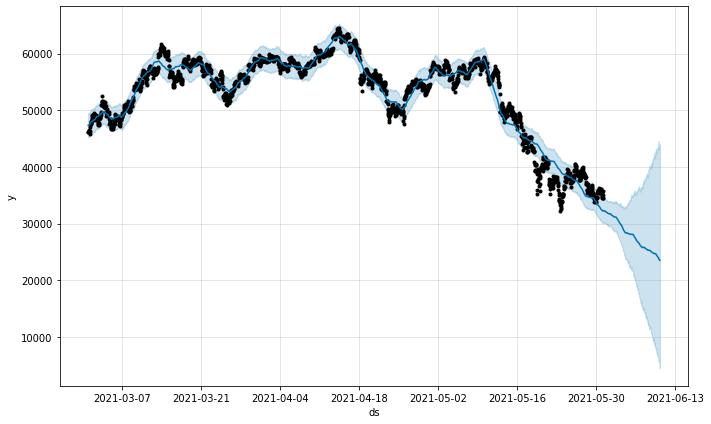

In [25]:
future = model.make_future_dataframe(periods=240, freq='H')
forecast = model.predict(future)
fig1 = model.plot(forecast)

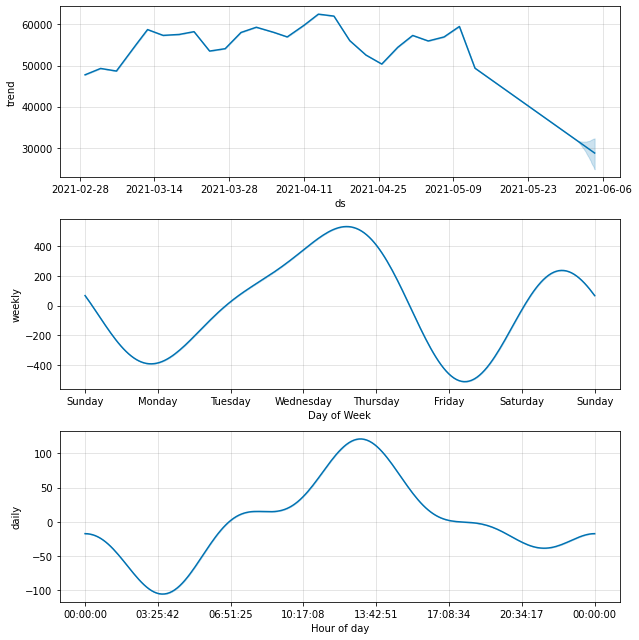

In [23]:
cccccc

In [27]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [29]:
plot_components_plotly(model, forecast)